# Forecasting - Daily Temperature Challenge

## Problem Statement

This is a univariate time series regression problem where you need to predict the minimum daily temperatures. Dataset contains temperatures for over 10 years (1981-1990) in the city Melbourne, Australia.The units are in degrees Celsius and there are 3466 observations. The source of the data is credited as the Australian Bureau of Meteorology. Prediction needs to be done for the next 6 months.

Expectation is to create a forecasting model of your choice (in Python or R) for the above forecasting problem and present it back to the panel. Evaluation will be based on understanding of forecasting concepts, approach and code walkthrough with very minimal importance on model accuracy.

## Data Exploration

In [3]:
import pandas as pd
import numpy as np
import statsmodels.tsa as sm 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMAResults, ARIMA
from statsmodels.graphics import tsaplots
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import warnings
from matplotlib import rcParams
sns.set()
figsize=(500, 100)
plt.style.use("ggplot")
rcParams["figure.figsize"] = [12, 9]
rcParams["xtick.labelsize"] = 15
rcParams["ytick.labelsize"] = 15
rcParams["font.size"] = 15

warnings.filterwarnings("ignore")

        Date  Temp
0 1981-01-01  20.7
1 1981-01-02  17.9
2 1981-01-03  18.8
3 1981-01-04  14.6
4 1981-01-05  15.8



 count    3466.000000
mean       11.209088
std         4.099361
min         0.000000
25%         8.300000
50%        11.100000
75%        14.000000
max        26.300000
Name: Temp, dtype: float64


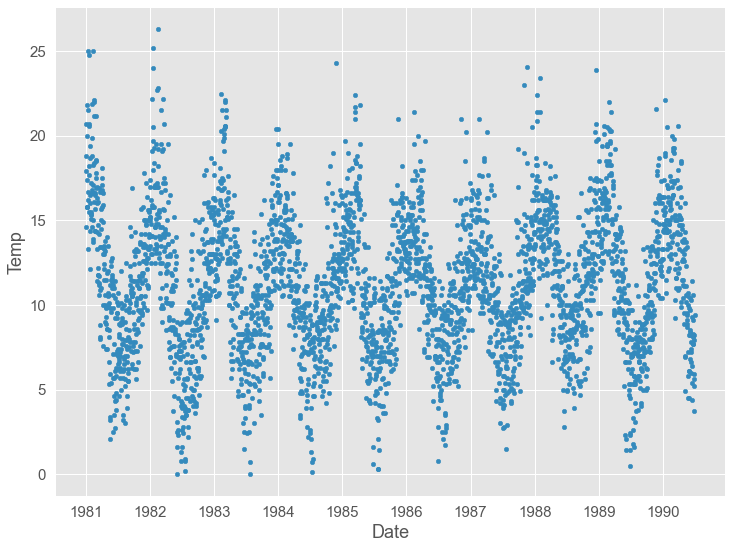

In [9]:
df=pd.read_excel('Daily Temp.xlsx', parse_dates=True)

print(df.head())

df.plot.scatter(x='Date',y='Temp')

print("\n\n\n",df.Temp.describe())

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
df=df.set_index('Date').asfreq('D')
df=df.sort_index()
df = df.dropna()
# Additive Decomposition
result_add = seasonal_decompose(df.Temp, model='additive', extrapolate_trend='freq', freq=365)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decomposition', fontsize=22)
plt.show()

ImportError: Can't determine version for numexpr

# Assumption (For AR Models)

### Stationarity Check

ADF TEST:

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

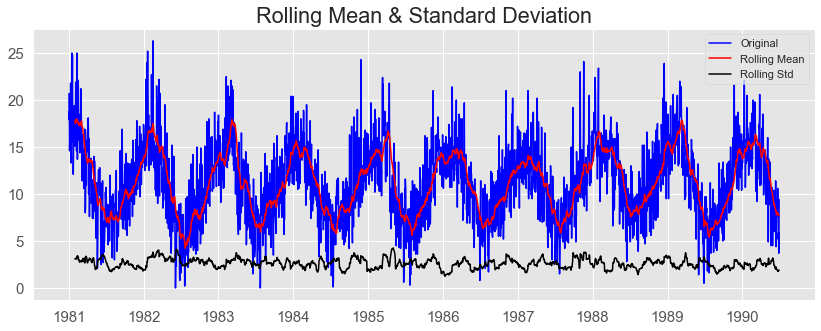

<Results of Dickey-Fuller Test>
Test Statistic                   -4.347012
p-value                           0.000368
#Lags Used                       19.000000
Number of Observations Used    3446.000000
Critical Value (1%)              -3.432249
Critical Value (5%)              -2.862379
Critical Value (10%)             -2.567217
dtype: float64


In [11]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df)

P<0.05 signifies, We have strong evidence againt Null hypothesis. Thus, rejecting the Null Hypothesis - Data is stationary

## Baseline Model

### ARIMA

Auto Regressive Integrated Moving Average is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

An ARIMA model is characterized by 3 terms: p, d, q
where,
p is the order of the AR term
q is the order of the MA term
d is the number of differencing required to make the time series stationary

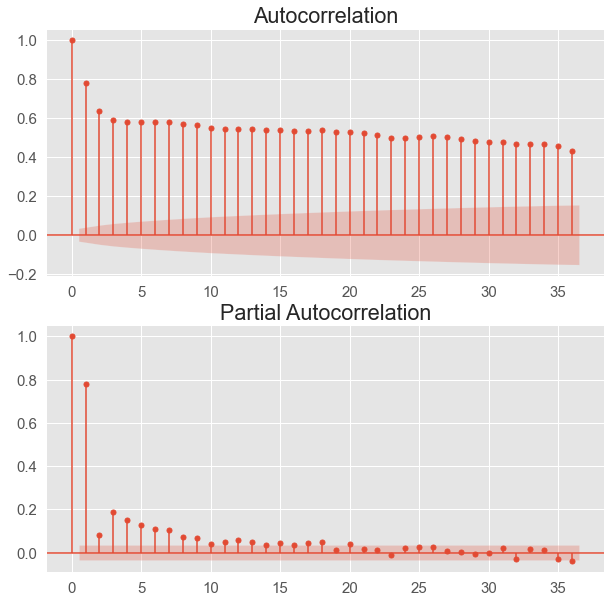

In [12]:
from pandas import read_csv
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
series = df.Temp
pyplot.figure()
pyplot.subplot(211)
plot_acf(series, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, ax=pyplot.gca())
pyplot.show()

In [14]:
# Shift the current temperature to the next day. 
predicted_df = df["Temp"].to_frame().shift(1).rename(columns = {"Temp": "Temp_pred" })
actual_df = df["Temp"].to_frame().rename(columns = {"Temp": "Temp_actual" })

# Concatenate the actual and predicted temperature
one_step_df = pd.concat([actual_df,predicted_df],axis=1)

# Select from the second row, because there is no prediction for today due to shifting.
one_step_df = one_step_df[1:]
one_step_df.head(10)

from sklearn.metrics import mean_squared_error as MSE
from math import sqrt

# Calculate the RMSE
temp_pred_err = MSE(one_step_df.Temp_actual, one_step_df.Temp_pred, squared=False)
print("The RMSE is",temp_pred_err)

The RMSE is 2.7296993052822316


In [ ]:
import numpy as np
import itertools
results = pd.DataFrame({"p": [], "d": [], "q":[], "P":[], "D":[], "Q":[], "aic": []})
results = results[['p','d','q','P','D','Q','aic']]

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(df.Temp,
                            order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            df_SARIMAX_fit = mod.fit()

            dd = pd.DataFrame({'p':[param[0]], 'd':[param[1]], 'q':[param[2]], "P":[param_seasonal[0]], "D":[param_seasonal[1]], "Q":[param_seasonal[2]],
                               'aic':[df_SARIMAX_fit.aic]})
            dd = dd[['p','d','q','P','D','Q','aic']]
            results = results.append(dd)
            print(param,param_seasonal,dd['aic'][0])
        except ValueError:
            pass

opt_sarima = (results[results.loc[:,'aic'] == results['aic'].min()].values[0]).astype('int64')
print(" - The minimum AIC value can be obtained by p={}, d={}, q={}, P={}, D={}, Q={} paramteres."
      .format(opt_sarima[0],opt_sarima[1], opt_sarima[2], opt_sarima[3], opt_sarima[4], opt_sarima[5]))
print(" - ARIMA({},{},{})({},{},{}) will be chosen as the best model.".format(opt_sarima[0],opt_sarima[1],
                                                                              opt_sarima[2],opt_sarima[3],
                                                                              opt_sarima[4], opt_sarima[5]))

In [15]:
# Fit the SARIMAX model using optimal parameters

mod =SARIMAX(one_step_df.Temp_actual,
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

model = mod.fit()

## Model Diagnostics

In [16]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        Temp_actual   No. Observations:                 3465
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood               -7955.396
Date:                            Wed, 01 Sep 2021   AIC                          15918.792
Time:                                    10:58:53   BIC                          15943.377
Sample:                                         0   HQIC                         15927.572
                                           - 3465                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4660      0.018     25.815      0.000       0.431       0.501
ma.L1         -0.9197      0.009   -105.346      0.000      -0.937      -0.903
ma.S.L12      -0.0006      0.018     -0.036      0.972      -0.035       0.034
sigma2         5.8920      0.132     44.552      0.000       5.633       6.151
===================================================================================
Ljung-Box (L1) (Q):                   8.73   Jarque-Bera (JB):                21.37
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

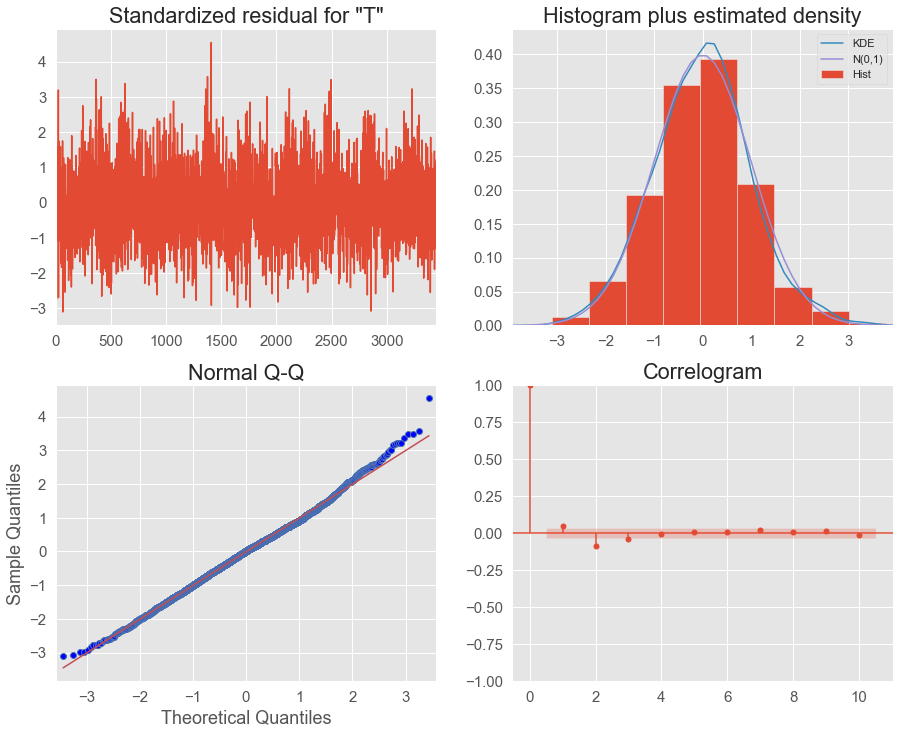

In [17]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()

<AxesSubplot:xlabel='Date'>

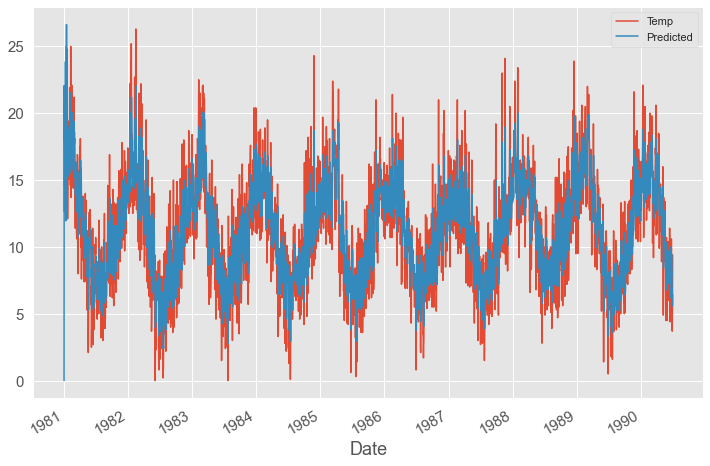

In [18]:
df_pred=model.predict()
results=df.join(df_pred)
results['Predicted']=results['predicted_mean']
del results['predicted_mean']
results[['Temp','Predicted']].plot(figsize=(12,8))

In [202]:
#metrics:
#root mean squared error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

#mean absolute percentage error
def MAPE(y_true, y_pred): 
    mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    return mape

#symmetric mean absolute error
def SMAPE(y_true, y_pred):
    smape = 100/len(y_true) * np.sum(2 * np.abs(np.array(y_pred) - np.array(y_true)) / (np.abs(np.array(y_true)) + np.abs(np.array(y_pred))))
    return smape

#mean squared logarithmic error:
def MSLE(y_true, y_pred):
    rmse = mean_squared_log_error(y_true, y_pred)
    return rmse

results.dropna(inplace=True)
rmse_arima = RMSE(results['Temp'].tolist(), results['Predicted'].to_list())
mape_arima = MAPE(results['Temp'].tolist(),  results['Predicted'].to_list())
smape_arima = SMAPE(results['Temp'].tolist(),  results['Predicted'].to_list())
msle_arima = MSLE(results['Temp'].tolist(),  results['Predicted'].to_list())

# Metrics is a dictionary to save metrics results for different methods.
Metrics = {"RMSE_ARIMA": [rmse_arima], "MAPE_ARIMA": [mape_arima], "SMAPE_ARIMA": [smape_arima],
          "MSLE_ARIMA": [msle_arima]}


pd.DataFrame(Metrics).T


NameError: name 'results' is not defined

## Forecast Values

<AxesSubplot:>

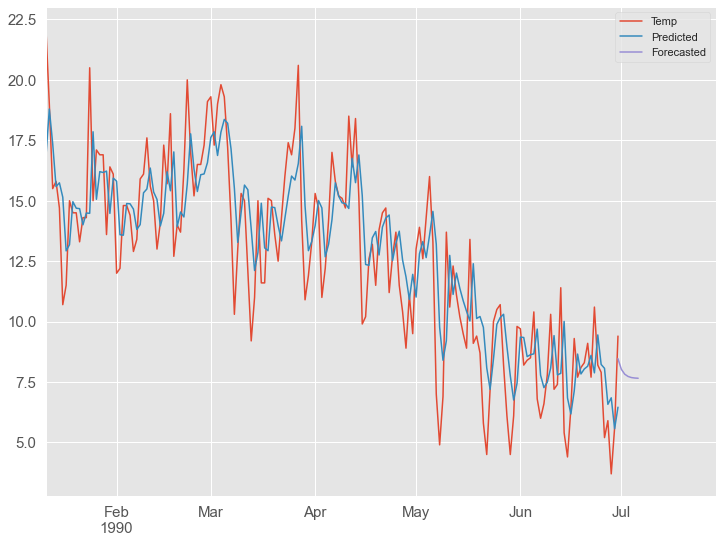

In [23]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(days=x)for x in range(0,30)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_datest_df.head()
future_datest_df['Forecasted_del']=future_datest_df['Temp']
del future_datest_df['Temp']
final_df=pd.concat([results,future_datest_df])

df_frct=pd.DataFrame()
df_frct['Forecasted']=model.forecast(7, alpha=0.05)  # 95% conf#predict(start=3467, end=3467+30,dynamic=False)  
df_frct.index=pd.date_range("1990-06-30", periods=7, freq="D")
del final_df['Forecasted_del']
final_df=final_df.join(df_frct)


final_df[-200:].plot()

# Forecast Using LSTM

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from keras import optimizers


# preparing independent and dependent features
def prepare_data(timeseries_data, n_features):
	X, y =[],[]
	for i in range(len(timeseries_data)):
		# find the end of this pattern
		end_ix = i + n_features
		# check if we are beyond the sequence
		if end_ix > len(timeseries_data)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)


# define input sequence
timeseries_data = df['Temp'].dropna().to_list()
# choose a number of time steps
n_steps = 10
# split into samples
X, y = prepare_data(timeseries_data, n_steps)


# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))


# define model
model = Sequential()
model.add(LSTM(45, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(35, activation='relu'))
model.add(Dense(1))
#optimizer = optimizers.Adam(clipvalue=0.5)
#model.compile(optimizer=optimizer, loss='mean_squared_error')
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=1)

Epoch 1/200
108/108 [==============================] - 1s 11ms/step - loss: 27.8523
Epoch 2/200
108/108 [==============================] - 1s 11ms/step - loss: 6.6320
Epoch 3/200
108/108 [==============================] - 1s 10ms/step - loss: 6.1282
Epoch 4/200
108/108 [==============================] - 1s 11ms/step - loss: 6.1139
Epoch 5/200
108/108 [==============================] - 1s 12ms/step - loss: 6.0285
Epoch 6/200
108/108 [==============================] - 1s 12ms/step - loss: 6.1698
Epoch 7/200
108/108 [==============================] - 1s 11ms/step - loss: 5.9896
Epoch 8/200
108/108 [==============================] - 1s 12ms/step - loss: 6.0468
Epoch 9/200
108/108 [==============================] - 1s 12ms/step - loss: 5.9240
Epoch 10/200
108/108 [==============================] - 1s 12ms/step - loss: 5.9508
Epoch 11/200
108/108 [==============================] - 1s 12ms/step - loss: 5.9680
Epoch 12/200
108/108 [==============================] - 1s 12ms/step - loss: 5.9254


In [ ]:
# demonstrate prediction for next 10 days
def pred_forecast(input_data):
    ndays=10
    x_input = input_data #df.Temp[-30:-20].values
    temp_input=list(x_input)
    lst_output=[]
    i=0

    while(i<ndays):

        if(len(temp_input)>3):
            x_input=array(temp_input[:])
            #print("{} day input {}".format(i,x_input))
            #print(x_input)
            x_input = x_input.reshape((1, n_steps, n_features))
            #print(x_input)
            yhat = model.predict(x_input, verbose=0)
            #print("{} day output {}".format(i,yhat))
            temp_input.append(yhat[0][0])
            temp_input=temp_input[1:]
            #print(temp_input)
            lst_output.append(yhat[0][0])
            i=i+1
        else:
            x_input = x_input.reshape((1, n_steps, n_features))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])
            lst_output.append(yhat[0][0])
            i=i+1
    return lst_output


In [210]:
# Evaluation Prediction
df['Temp_Predicted_LSTM']=np.nan
df.Temp_Predicted_LSTM[-20:-10]=pd.Series(pred_forecast(df.Temp[-20:-10].values))
actual=df.Temp[-20:-10].values
predicted=df.Temp_Predicted_LSTM[-20:-10].values
rmse_arima = RMSE(actual, predicted)
mape_arima = MAPE(actual, predicted)
smape_arima = SMAPE(actual, predicted)
msle_arima = MSLE(actual, predicted)

# Metrics is a dictionary to save metrics results for different methods.
Metrics_LSTM = {"RMSE_ARIMA": [rmse_arima], "MAPE_ARIMA": [mape_arima], "SMAPE_ARIMA": [smape_arima],
          "MSLE_ARIMA": [msle_arima]}

pd.DataFrame(Metrics_LSTM).T


,0
RMSE_ARIMA,1.847666
MAPE_ARIMA,19.891285
SMAPE_ARIMA,20.844629
MSLE_ARIMA,0.054880


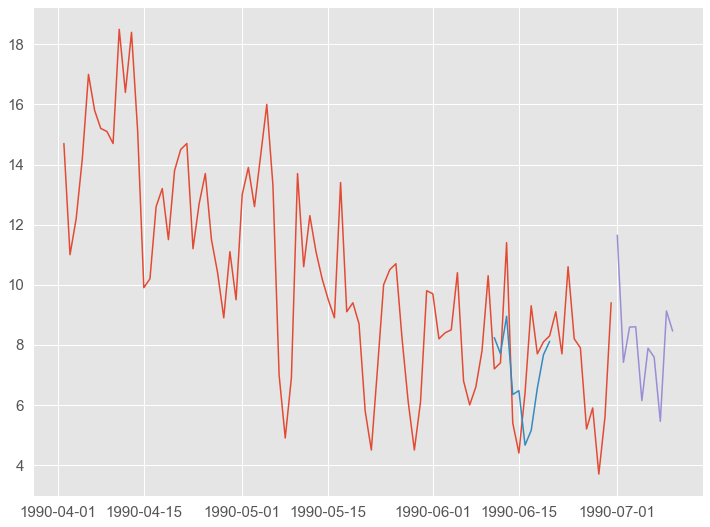

In [212]:
#Forecast for next 10 days
df_lstm_fr=pd.DataFrame(pred_forecast(df.Temp[-10:].values))
df_lstm_fr.columns=['Temp_Forecasted_LSTM']
df_lstm_fr.index=[df.index[-1]+ DateOffset(days=x)for x in range(1,11)]
df_final=df.append(df_lstm_fr)
plt.plot(df_final[-100:])